# Empirical data features

This is the first notebook in a series illustrating the workflow of the usecase of virtual brain modeling and inference in the context of neurodegenerative disease (NDD). Here, as a first step, we analyze the empirical data features.

In [1]:
!date -I

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

from src.data.data_loader import Synthetic

2023-05-31


/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


The `Synthetic` class contains all the helper codes to work with this particular dataset, such as loading the subjects' metadata or the data of individual subjects. 

In [11]:
dset = Synthetic()

In [3]:
dset.subjects_metadata

,group,eta_limbic
id,,
sub-001,AD,-4.0
sub-002,AD,-4.0
sub-003,AD,-4.0
sub-004,AD,-4.0
sub-005,AD,-4.0
...,...,...
sub-111,NORM,-4.5
sub-112,NORM,-4.5
sub-113,NORM,-4.5


We can inspect the data of individual subjects:

In [4]:
subject = dset.subjects[0]

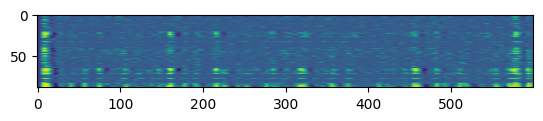

In [5]:
plt.imshow(dset.load_bold(subject).T)

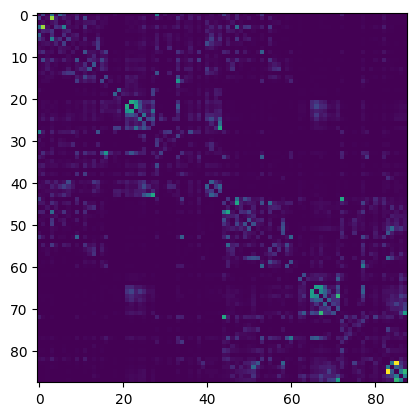

In [6]:
plt.imshow(dset.load_SC(subject))

Now we can loop over the subjects and compute the summary statistics of the data. The choise of particular measures will be different for every usecase, here we look on the following:
- structural connectivity within the limbic network
- homotopic functional connectivity
- fluidity of the functional connectivity dynamics within the limbic network

In [7]:
from src.data_features.summary_statistics import compute_summary_statistics

In [8]:
import pandas as pd

Let's start with looking at the connectivity strength within the limbic system across the groups.

The labels and indices of the limbic system can be recovered from the parcellation attribute of the dataset:

In [12]:
limbic_labels, limbic_idx, _, _, _, _  = dset.parcellation.load_limbic()

In [13]:
np.r_[limbic_labels]

array(['Hippocampus_R', 'ParaHippocampal_R', 'Cingulum_Ant_R',
       'Cingulum_Mid_R', 'Cingulum_Post_R', 'Amygdala_R',
       'Temporal_Pole_Sup_R', 'Temporal_Mid_R', 'Hippocampus_L',
       'ParaHippocampal_L', 'Cingulum_Ant_L', 'Cingulum_Mid_L',
       'Cingulum_Post_L', 'Amygdala_L', 'Temporal_Pole_Sup_L',
       'Temporal_Mid_L'], dtype='<U19')

With the indices, we can then create the subnetwork of a an array `SC` as simple as `SC[limbic_idx,:][:, limbic_idx]`. 

Looping over all subjects, we get the follwing data frame:

In [14]:
df = pd.DataFrame(
    dict(
        id = dset.subjects,
        sc_limbic = [dset.load_SC(subject)[limbic_idx,:][:, limbic_idx].sum() for subject in dset.subjects]
    )
)
df

,id,sc_limbic
0,sub-001,5.037890
1,sub-002,3.646875
2,sub-003,2.429534
3,sub-004,3.482776
4,sub-005,1.420778
...,...,...
110,sub-111,4.402373
111,sub-112,5.075955
112,sub-113,3.369252
113,sub-114,3.847352


Merging this with the subject metadata, we can look at the group differences.

In [15]:
df = dset.subjects_metadata.reset_index().merge(df, on='id')
df

,id,group,eta_limbic,sc_limbic
0,sub-001,AD,-4.0,5.037890
1,sub-002,AD,-4.0,3.646875
2,sub-003,AD,-4.0,2.429534
3,sub-004,AD,-4.0,3.482776
4,sub-005,AD,-4.0,1.420778
...,...,...,...,...
110,sub-111,NORM,-4.5,4.402373
111,sub-112,NORM,-4.5,5.075955
112,sub-113,NORM,-4.5,3.369252
113,sub-114,NORM,-4.5,3.847352


sc_limbic    Axes(0.125,0.11;0.775x0.77)
dtype: object

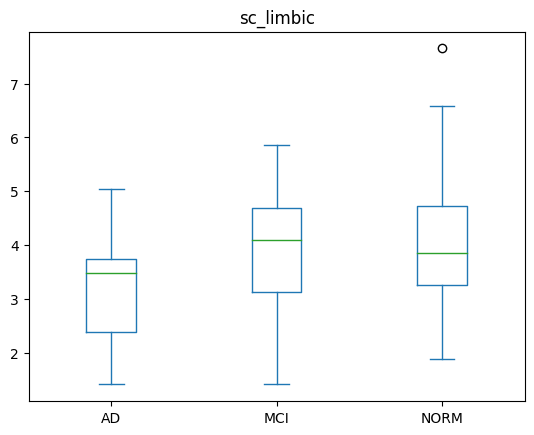

In [16]:
df.plot(kind='box',by='group', column='sc_limbic')

Next we look at the functional data features. We start by defining which data features and summary statistics we want to compute. The distinction between data features and summary statistics is that the summary statistics are scalars, whereas a data feature can be an array of arbitray dimensionality. 

For example, we compute the FC and FCD *data features*, and summarize them with e.g. strength of the interhemispheric FC connections, and the variablity of FCD. 

The computation of the data features and the summary statistics is best defined as a function of the time-series:

In [17]:
bold = dset.load_bold(subject)

In [23]:
from src.data_features.fc import compute_fcd_roi, compute_fc, fc_stats, fcd_stats

To get more information on the individual functions, please use the built-in help:

In [25]:
help(compute_fcd_roi)

Help on function compute_fcd_roi in module src.data_features.fc:

compute_fcd_roi(ts, roi_idx, win_len=30, win_sp=1)
    Compute dynamic functional connectivity with FC matrix filtered to selected regions.
    
    Arguments:
        ts:       time series of shape [time,nodes]
        roi_idx:  binary vector defining the ROI [nodes]
        win_len:  sliding window length in samples
        win_sp:   sliding window step in samples
    Returns:
        FCD: matrix of functional connectivity dynamics
        fcs: windowed functional connectivity matrices
        speed_fcd: rate of changes between FC frames



Let's pick the functional connectivity, FCD, and their versions filtered to a subnetwork, in this case the limbic regions.

In [44]:
def summary_stats(bold, limbic_id, win_len=30):
    
    # data features first
    FC = compute_fc(bold)
    FCD_limbic, fcs, _ = compute_fcd_roi(bold, win_len=win_len, roi_idx=limbic_idx)
    
    # summary stats
    fc_ss = fc_stats(FC)
    fcd_ss = fcd_stats(FCD_limbic, fcs, win_len=win_len, prefix='fcd_limbic')
    
    # concatenate to a single vector
    return pd.concat([fc_ss, fcd_ss])

In [45]:
summary_stats(bold, limbic_idx)

/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


fc_sum                         NaN
fc_max                         NaN
fc_min                         NaN
fc_mean                        NaN
fc_std                         NaN
fc_q0.05                       NaN
fc_q0.25                       NaN
fc_q0.5                        NaN
fc_q0.75                       NaN
fc_q0.95                       NaN
fc_homotopic_sum               NaN
fc_homotopic_max               NaN
fc_homotopic_min               NaN
fc_homotopic_mean              NaN
fc_homotopic_std               NaN
fc_homotopic_q0.05             NaN
fc_homotopic_q0.25             NaN
fc_homotopic_q0.5              NaN
fc_homotopic_q0.75             NaN
fc_homotopic_q0.95             NaN
fcd_limbic_sum        63579.532837
fcd_limbic_max            0.815802
fcd_limbic_min            0.000000
fcd_limbic_mean           0.195690
fcd_limbic_std            0.225013
fcd_limbic_q0.05          0.000000
fcd_limbic_q0.25          0.000000
fcd_limbic_q0.5           0.000000
fcd_limbic_q0.75    

Now we can apply this to the whole cohort to construct the table of the summary statistics for each subject.

In [46]:
df = pd.DataFrame(
    [ 
        summary_stats(dset.load_bold(subject), limbic_idx) 
        for subject in dset.subjects 
    ],
    index=dset.subjects
)

/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/izaak/local_repos/nostromo/virtual_ndd_brain_WT_usecase/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev

Now we can plot the selected statistics of interest across the groups.

fcd_limbic_std    Axes(0.125,0.11;0.775x0.77)
dtype: object

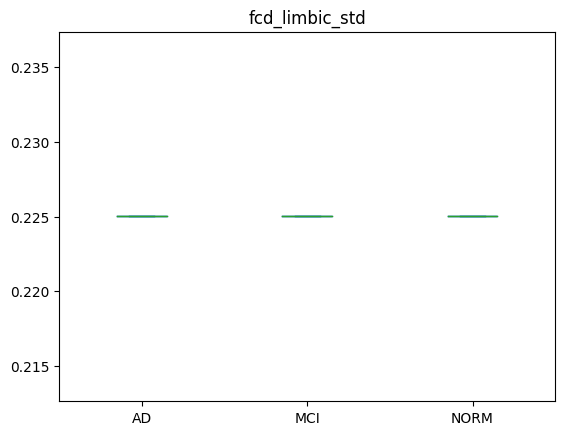

In [60]:
df.join(dset.subjects_metadata).plot(kind='box',by='group', column='fcd_limbic_std')

Equipped with these observations, we can start formulating the mechanistic model relating the structural and functional changes in the NDD.